In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from torchvision.io import read_image
import torchvision.transforms as transforms

from torchvision.transforms import v2 as T

import os
import torch

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F
import json

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

import utils
import wget

from engine import train_one_epoch, evaluate


%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import matplotlib.patches as patches
import cv2
import torchvision.transforms.functional as TF

plt.rcParams['figure.figsize'] = [12, 9]

In [2]:

def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

In [42]:


class WtDataset(torch.utils.data.Dataset):
    tank_label_mapping = {'symbol_ht' : 0, 'symbol_lt' : 1, 'symbol_mt' : 2, 'symbol_spaaa' : 3, 'symbol_td': 4}
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = [x for x in list(sorted(os.listdir(root))) if x[-3:] == 'png' or x[-3:] == 'jpg']
        print('imgs list!', self.imgs)
   

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, self.imgs[idx])
        # mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = read_image(img_path)
 
        img = tv_tensors.Image(img)
       
        img = img[:3, :, :]
        img = img / 255.0
        fig, ax = plt.subplots()
        # ax.imshow(img.permute(1,2,0))

        boxes, labels = self.get_tank_boxes(img_path=img_path, img_canvas_size=F.get_size(img))

        # suppose all instances are not crowd
        # iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:

        target = {}
        # target["boxes"] = tv_tensors.BoundingBoxes(
        #     boxes, format="XYXY", canvas_size=F.get_size(img)
        # )
        
        # target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        # target["image_id"] = image_id
        # target["area"] = area
        target['boxes'] = boxes
        # target["iscrowd"] = iscrowd    


        if self.transforms is not None:
            img, target = self.transforms(img, target)
        
        show_boxes(image=img, target=target)
        return img, target
    
    def get_tank_boxes(self, img_path, img_canvas_size):

        json_path = f'{img_path[:-4]}_loc.json'
        # print('json path: ', json_path)
        with open(json_path, 'r') as file:
            data = json.load(file)
        bound_box_list = []
        label_list = []


        for tank in data['data']:
            bound_box_list.append([tank['x_min'], tank['y_min'], tank['x_max'], tank['y_max']])
            label_list.append(WtDataset.tank_label_mapping[tank['name']])

        bound_box_tensor = torch.tensor(bound_box_list, dtype=torch.float16)
      
        # print('bounding box tensor ', bound_box_tensor)
        label_tensor = torch.tensor(label_list, dtype=torch.int64)

        return tv_tensors.BoundingBoxes(bound_box_tensor, format="XYXY", canvas_size=img_canvas_size), label_tensor
    
    


    def __len__(self):
        return len(self.imgs)

In [ ]:
def show_boxes(self, image, target):

    # image = image.permute(1,2,0)
    image_np = TF.to_pil_image(image.clone()).convert("RGB")
    image_np = np.array(image_np)   

    boxes = target['boxes']
    labels = target['labels']
    # print(boxes)
    # fig, ax = plt.subplots()
    label_color_map = {0:(255,0,0), 1: (0,255,0), 2: (0,0,255), 3:(255,255,0), 4:(0,255,255)}

    # HOPEFULLY we have less categories thatn named colors...
    for box, label  in zip(boxes, labels):
        print("label : ", label)           
        box = box.to(torch.int)
        print("BOXXX", box, "LABELL ", label)      
        # rectangle = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=2, edgecolor=color, facecolor='none')
        # ax.add_patch(rectangle)
        cv2.rectangle(image_np, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), label_color_map[label.item()], 1)
        # break
    plt.imshow( image_np)

imgs list! ['38_parallel.png', 'abandoned_factory.png', 'advance_to_rhine.jpg', 'alaska.png', 'american_desert.png', 'ardeens.png', 'elalamen.jpg', 'finland.png', 'frozen_pass.jpg', 'italy.jpg', 'jungle.jpg', 'karelia.jpg']
label :  tensor(0)
BOXXX tensor([569,  70, 581,  79], dtype=torch.int32) LABELL  tensor(0)
label :  tensor(0)
BOXXX tensor([518, 573, 530, 582], dtype=torch.int32) LABELL  tensor(0)
label :  tensor(0)
BOXXX tensor([527,  86, 539,  95], dtype=torch.int32) LABELL  tensor(0)
label :  tensor(0)
BOXXX tensor([161, 232, 173, 241], dtype=torch.int32) LABELL  tensor(0)
label :  tensor(0)
BOXXX tensor([645, 563, 657, 572], dtype=torch.int32) LABELL  tensor(0)
label :  tensor(0)
BOXXX tensor([724, 737, 736, 746], dtype=torch.int32) LABELL  tensor(0)
label :  tensor(0)
BOXXX tensor([ 45, 475,  57, 484], dtype=torch.int32) LABELL  tensor(0)
label :  tensor(0)
BOXXX tensor([195,  87, 207,  96], dtype=torch.int32) LABELL  tensor(0)
label :  tensor(0)
BOXXX tensor([305, 456, 317, 

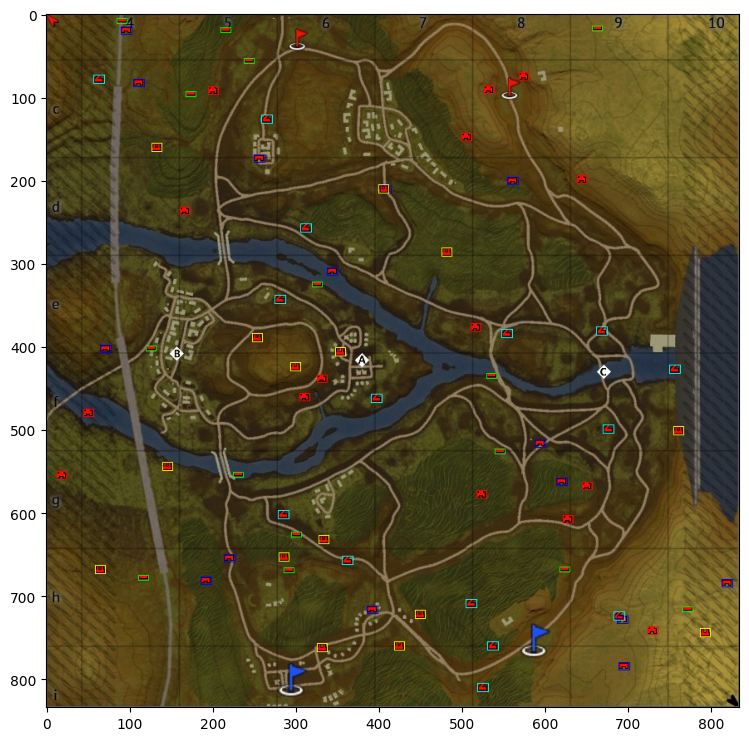

In [41]:
dataset = WtDataset(
    "D:/Stuff/data_science/tf_course/pytorch/wt_data/processed", None #get_transform(train=True)
)
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=1,
    # shuffle=True,
    # num_workers=4,
    collate_fn=None,
)
# # For Training
images, targets = next(iter(data_loader))

In [5]:
from PIL import Image


for img_file in [x for x in list(os.listdir('D:/Stuff/data_science/tf_course/pytorch/wt_data/processed')) if x[-4:] == '.png' or x[-4:] == '.jpg']:
    image = Image.open('D:/Stuff/data_science/tf_course/pytorch/wt_data/processed/' + img_file)
    print(img_file)
    print(image.size)
    print(image.mode)

38_parallel.png
(834, 834)
RGBA
abandoned_factory.png
(834, 834)
RGBA
advance_to_rhine.jpg
(834, 834)
RGB
alaska.png
(834, 834)
RGB
american_desert.png
(834, 834)
RGBA
ardeens.png
(834, 834)
RGB
elalamen.jpg
(834, 834)
RGB
finland.png
(834, 834)
RGBA
frozen_pass.jpg
(834, 834)
RGB
italy.jpg
(834, 834)
RGB
jungle.jpg
(834, 834)
RGB
karelia.jpg
(834, 834)
RGB


In [8]:


wget.download(
    "https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py"
)
wget.download(
    "https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py"
)
wget.download(
    "https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py"
)
wget.download(
    "https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py"
)
wget.download(
    "https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py"
)

'transforms.py'

In [10]:
len(torch.rand(4, 3, 600, 1200).shape)

4

imgs list! ['38_parallel.png', 'abandoned_factory.png', 'advance_to_rhine.jpg', 'alaska.png', 'american_desert.png', 'ardeens.png', 'elalamen.jpg', 'finland.png', 'frozen_pass.jpg', 'italy.jpg', 'jungle.jpg', 'karelia.jpg']
CATEGORYY tensor([[704., 232., 713., 244.],
        [418., 173., 427., 185.],
        [507., 377., 516., 389.],
        [295., 124., 304., 136.],
        [554., 717., 563., 729.],
        [175., 107., 184., 119.],
        [366., 574., 375., 586.],
        [800., 560., 809., 572.],
        [619., 395., 628., 407.],
        [815., 698., 824., 710.],
        [332., 325., 341., 337.],
        [625., 518., 634., 530.],
        [568., 280., 577., 292.],
        [110., 328., 119., 340.],
        [760., 161., 769., 173.],
        [418., 537., 424., 549.],
        [120., 294., 126., 306.],
        [787., 736., 793., 748.],
        [230., 277., 236., 289.],
        [268., 511., 274., 523.],
        [593., 387., 599., 399.],
        [578., 550., 584., 562.],
        [341.,  47

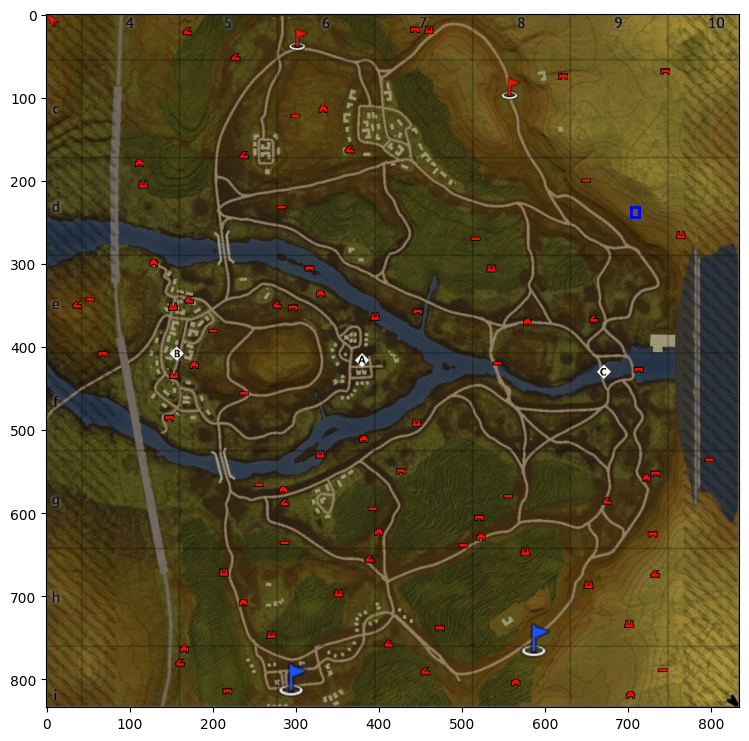

In [56]:



model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
dataset = WtDataset(
    "D:/Stuff/data_science/tf_course/pytorch/wt_data/processed", None #get_transform(train=True)
)
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=1,
    # shuffle=True,
    # num_workers=4,
    collate_fn=None,
)
# # For Training
images, targets = next(iter(data_loader))

show_boxes(image=images[0].permute(1,2,0), target=targets)

# print("images!!!", len(images))
# print('targets!!!!',targets)
# print(targets.keys())
# print(images.shape)

# print('labelsss', targets['labels'])

# targets_final  = []
# for batch in range(2):
#     target = {}
#     for k,v in targets.items():
#         target[k] = v[batch]
#     targets_final.append(target)


    
# output = model(images, targets_final)  # Returns losses and detections
# print(output)

# # For inference
# model.eval()

# predictions = model(images[:2])  # Returns predictions
# print(predictions[0])

In [13]:
# plot boxes on images:

def plot_boxes(image, boxes=None):
    # Create figure and axes
    fig, ax = plt.subplots(1)

    # Display the image
    ax.imshow(image)

    # Plot each bounding box
    for box in boxes:
        x_min, y_min, x_max, y_max = box
        width = x_max - x_min
        height = y_max - y_min

        # Create a rectangle patch
        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='r', facecolor='none')

        # Add the rectangle to the axes
        ax.add_patch(rect)

    # Show the plot
    plt.show()

In [19]:
# Test the custom data class
dataset = WtDataset(
    "D:/Stuff/data_science/tf_course/pytorch/wt_data/processed", None
)

for data in dataset:
    print("data", data[1].keys())
    # plot_boxes(data[0].permute(1,2,0))


imgs list! ['38_parallel.png', 'abandoned_factory.png', 'advance_to_rhine.jpg', 'alaska.png', 'american_desert.png', 'ardeens.png', 'elalamen.jpg', 'finland.png', 'frozen_pass.jpg', 'italy.jpg', 'jungle.jpg', 'karelia.jpg']
data dict_keys(['labels', 'boxes'])
data dict_keys(['labels', 'boxes'])
data dict_keys(['labels', 'boxes'])
data dict_keys(['labels', 'boxes'])
data dict_keys(['labels', 'boxes'])
data dict_keys(['labels', 'boxes'])
data dict_keys(['labels', 'boxes'])
data dict_keys(['labels', 'boxes'])
data dict_keys(['labels', 'boxes'])
data dict_keys(['labels', 'boxes'])
data dict_keys(['labels', 'boxes'])
data dict_keys(['labels', 'boxes'])


In [37]:


# train on the GPU or on the CPU, if a GPU is not available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# our dataset has two classes only - background and person
num_classes = 2
# use our dataset and defined transformations
dataset = PennFudanDataset(
    "D:/Stuff/data_science/tf_course/pytorch/PennFudanPed", get_transform(train=True)
)
dataset_test = PennFudanDataset(
    "D:/Stuff/data_science/tf_course/pytorch/PennFudanPed", get_transform(train=False)
)

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    # shuffle=True,
    # num_workers=4,
    collate_fn=utils.collate_fn,
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    # shuffle=False,
    # num_workers=4,
    collate_fn=utils.collate_fn,
)

# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# let's train it just for 2 epochs
num_epochs = 2

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

print("That's it!")

Epoch: [0]  [ 0/60]  eta: 0:53:41  lr: 0.000090  loss: 6.6371 (6.6371)  loss_classifier: 1.2772 (1.2772)  loss_box_reg: 0.1491 (0.1491)  loss_mask: 5.1867 (5.1867)  loss_objectness: 0.0222 (0.0222)  loss_rpn_box_reg: 0.0019 (0.0019)  time: 53.6851  data: 0.1715  max mem: 2400
Epoch: [0]  [10/60]  eta: 0:12:44  lr: 0.000936  loss: 2.1617 (3.0439)  loss_classifier: 0.6419 (0.6549)  loss_box_reg: 0.2143 (0.2259)  loss_mask: 1.3175 (2.1413)  loss_objectness: 0.0137 (0.0159)  loss_rpn_box_reg: 0.0050 (0.0060)  time: 15.2960  data: 0.1279  max mem: 2659


KeyboardInterrupt: 